In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [3]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, )#, dtype='Int64')


In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [6]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,10010000001,2,81,8,91,9,6,21,21,1,71,41,7,4,12,4,20,2,2,1,51,5,1.0
1,20010000006,1,75,7,43,4,6,6,13,2,71,64,7,6,12,9,4,12,4,13,12,1,1.0
2,30010000011,1,76,7,43,4,6,6,16,3,54,81,5,8,7,12,6,6,4,18,36,3,2.0
3,40010000013,3,75,7,43,4,4,6,13,1,71,36,7,3,12,11,11,19,4,6,21,2,1.0
4,50010000015,2,33,3,44,4,6,7,12,1,71,42,7,4,12,5,14,3,3,1,14,1,2.0


In [7]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    #model.fit(X_train, y_train)
    y_pred_test = (model.predict(X_test) > 0.5).astype("int64")
    y_pred_train = (model.predict(X_train) > 0.5 ).astype("int64")

    print("test set : ")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test)) 
    print("train set : ")
    print(confusion_matrix(y_train, y_pred_train )) # ajouter 
    print(classification_report(y_train, y_pred_train ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()



def vingtiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne Top_mon :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data



In [8]:

from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score

In [9]:
###########################################################################################################
#                                                   KERAS 
###########################################################################################################


In [10]:
##########################################
# SANS LES VARIABLES CORR  ET ENCODAGE DUMMIES
#########################################

In [11]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F",
                "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])
train_Y_s[train_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])
test_Y_s[test_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [23]:

from keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.utils import class_weight 
# np.random.seed(0)






# Create function returning a compiled network

def create_network(number_of_features):
    # numbers of features
    number_of_features = number_of_features  #train_X_s.shape[1]

    # start neural network
    network = models.Sequential()

    # add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=200, activation="sigmoid", input_shape = (number_of_features, ) ))

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=100, activation = "sigmoid" ) )

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=50, activation = "sigmoid" ) )    

    # add fully connected layer with a ReLu activation function
    #network.add(layers.Dense(units=10, activation = "relu" ) )    

    # add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation = "sigmoid" ) )

    # compile neural network
    network.compile(loss="binary_crossentropy", optimizer ="adam", metrics = ["accuracy"] )


    return network


In [24]:
# 
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_Y_s ),train_Y_s)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6132304166917928, 1: 2.7078873089417903}

Text(0, 0.5, 'Accuracy Score')

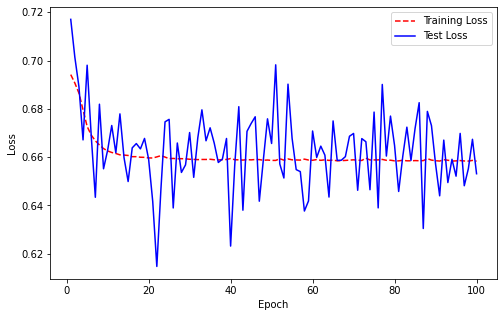

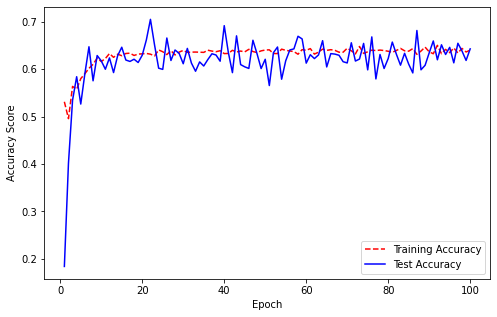

In [25]:
# 
# train neural network
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=100, verbose=0, batch_size=6780,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# visualize loss history
plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_loss, "r--" )
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# get training and test accuracy histories

training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")


Text(0, 0.5, 'Accuracy Score')

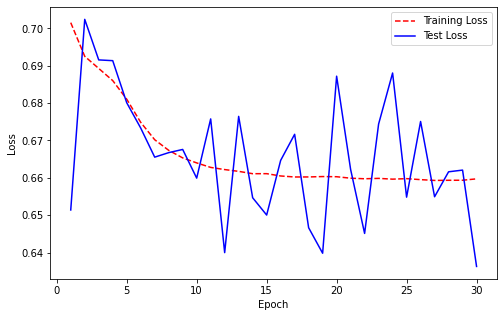

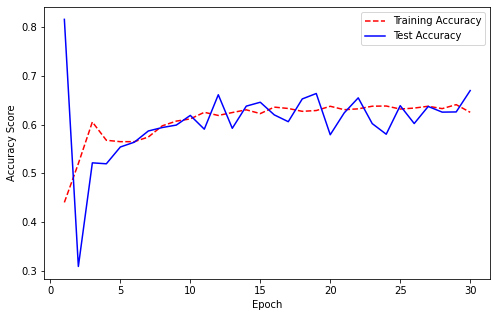

In [26]:
# 
# train neural network
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=30, verbose=0, batch_size=6780,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# visualize loss history
plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_loss, "r--" )
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# get training and test accuracy histories

training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")


In [31]:
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=10, verbose=0, batch_size=6780,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

evaluation(network, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall", plot=False)

test set : 
[[13817  6927]
 [ 2273  2406]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     20744
           1       0.26      0.51      0.34      4679

    accuracy                           0.64     25423
   macro avg       0.56      0.59      0.55     25423
weighted avg       0.75      0.64      0.68     25423

train set : 
[[55748 27167]
 [ 8985  9792]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     82915
           1       0.26      0.52      0.35     18777

    accuracy                           0.64    101692
   macro avg       0.56      0.60      0.55    101692
weighted avg       0.75      0.64      0.68    101692

GRAPHIQUE NON DEMANDE


In [32]:
# TRAIN SET TEST SET
vingtiles(model= network, data_orig= data, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_logistic_regression.xlsx")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


                   IDENT     PROBA
18413    184140010261341  0.258383
20252    202530010263334  0.259448
20250    202510010263334  0.259448
20251    202520010263334  0.259448
10101    101020010254791  0.259573
...                  ...       ...
42644    426450010357284  0.816586
112466  1124670010522219  0.816586
61641    616420010372835  0.816586
77961    779620010392936  0.817952
107367  1073680010503920  0.818753

[127115 rows x 2 columns]
0.816586    50
0.601692    33
0.773440    33
0.709488    26
0.717952    23
            ..
0.575347     1
0.412674     1
0.475175     1
0.433300     1
0.721022     1
Name: PROBA, Length: 96055, dtype: int64
                 PROBA
18413   (0.257, 0.317]
20252   (0.257, 0.317]
20250   (0.257, 0.317]
20251   (0.257, 0.317]
10101   (0.257, 0.317]
...                ...
42644   (0.687, 0.819]
112466  (0.687, 0.819]
61641   (0.687, 0.819]
77961   (0.687, 0.819]
107367  (0.687, 0.819]

[127115 rows x 1 columns]
Top_mon            1     2  TOTAL
TRANCHES  

In [28]:
#k-fold cross-validation neural networks ( FOR SMALLER DATA )

# wrap Keras model so it can be used by scikit-learn 
neural_network = KerasClassifier(build_fn =lambda:create_network(number_of_features=train_X_s.shape[1]), epochs=8, batch_size=6780, verbose=0)

# evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, train_X_s, train_Y_s, cv = 4, n_jobs=2, scoring="accuracy")



array([0.81414467, 0.81807812, 0.81367266, 0.81552138])

In [29]:
101692-6780*14

6772

In [30]:
####################################################################################################
#
#                                       UNDER-SAMPLING  ET OVER-SAMPLING
#
####################################################################################################

In [ ]:
# Résultat du traitement sur le train set (under-sampling et over-sampling)
abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
abc_np = abc_test.to_numpy(dtype="Int64")

X_resampled = abc_np[:,:-1]
y_resampled = abc_np[:, abc_np.shape[1] -1 ]
y_resampled[y_resampled==2]=0
y_resampled[y_resampled==1]=1


In [ ]:
X_resampled.shape, y_resampled.shape

((160026, 269), (160026,))

Text(0, 0.5, 'Accuracy Score')

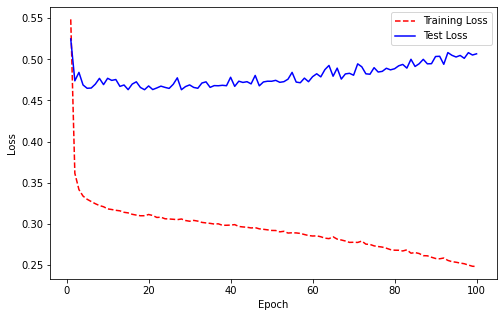

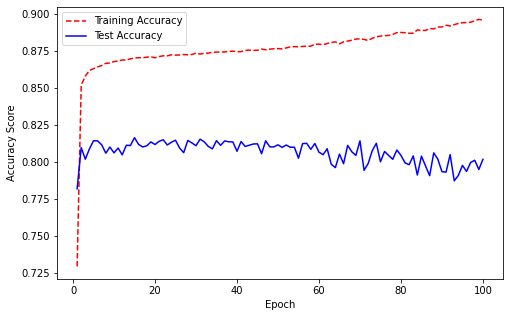

In [ ]:
# 
# train neural network
network = create_network( number_of_features = X_resampled.shape[1])
history= network.fit( X_resampled, y_resampled, epochs=100, verbose=0, batch_size=6780, validation_data=(test_X_s, test_Y_s))

# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# visualize loss history
plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_loss, "r--" )
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# get training and test accuracy histories

training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")


In [ ]:
network = create_network( number_of_features = X_resampled.shape[1])
history= network.fit( X_resampled, y_resampled, epochs=1, verbose=0, batch_size=6780, validation_data=(test_X_s, test_Y_s))
evaluation(network, X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)

test set : 
[[18935  1809]
 [ 3712   967]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     20744
           1       0.35      0.21      0.26      4679

    accuracy                           0.78     25423
   macro avg       0.59      0.56      0.57     25423
weighted avg       0.75      0.78      0.76     25423

train set : 
[[73338  6675]
 [17999 62014]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     80013
           1       0.90      0.78      0.83     80013

    accuracy                           0.85    160026
   macro avg       0.85      0.85      0.85    160026
weighted avg       0.85      0.85      0.85    160026

GRAPHIQUE NON DEMANDE


array([2, 1, 2, ..., 1, 1, 1])

In [ ]:
#k-fold cross-validation neural networks ( FOR SMALLER DATA )

# wrap Keras model so it can be used by scikit-learn 
neural_network = KerasClassifier(build_fn =lambda:create_network(number_of_features=X_resampled.shape[1]), epochs=100, batch_size=6780, verbose=0)

# evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, X_resampled, y_resampled, cv = 4, n_jobs=2)



array([0.74496961, 0.79521084, 0.87861818, 0.97575366])

In [ ]:
# wrap keras model s
neural_network = KerasClassifier(build_fn = create_network, verbose =0)

# create hyperparameters 
hyperparameters = {optimizer = ["rmsprop", "adam"] , epochs = [5, 10], batch_size = [5, 10, 100]   }

grid = GridSearchCV(estimator = neural_network, param_grid=hyperparameters)

result = grid.fit( , )

result.best_params_

dtype('int64')